<a href="https://colab.research.google.com/github/AtsushiNi/myLeprecon/blob/master/niihama/analyze_1-4/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/fujiisoup/pyspectra.git
!pip install lmfit
!pip install netCDF4

  Cloning https://github.com/fujiisoup/pyspectra.git to /tmp/pip-req-build-0222o5p3
  Running command git clone -q https://github.com/fujiisoup/pyspectra.git /tmp/pip-req-build-0222o5p3
  Created wheel for pyspectra: filename=pyspectra-0.0.1-cp36-none-any.whl size=19899 sha256=0dc36ce2d8dbc5e4f14f2c3456d2a6876427318d785eccd5d24ad46bd8d70e0b
  Stored in directory: /tmp/pip-ephem-wheel-cache-qdbr776j/wheels/a7/c4/4a/152e6df7ccc3c6838abee31c086e30a3690c80966eb588e7a2
Successfully built pyspectra


In [2]:
import os
from os.path import join
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import integrate
import pyspectra
import lmfit
from lmfit.models import VoigtModel, ConstantModel, GaussianModel
from lmfit.lineshapes import voigt

In [3]:
data_path = '/content/drive/MyDrive/研究室/myLeprecon/SpectrometerData/20210104_niihama_2'
image_path = '/content/drive/MyDrive/研究室/images/analyze_1-4'
print(os.path.exists(data_path))

True


In [4]:
file_names = [f'H2_{420000 + 5000*i}.nc' for i in np.arange(10)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data_array['exposure'] = data_array.attrs['exposure']
    data_array['slit_width'] = data_array.attrs['slit_width']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

plasma_data = []
for i, p in enumerate(data['motor_coordinate']):
  d = data.sel(motor_coordinate=p).copy()
  d['long_x'] = d['x'][::-1] - 1000 * i
  d['x'] = data['x']
  plasma_data.append(d.sum('y'))
plasma_data = xr.concat(plasma_data, dim='motor_coordinate')

In [5]:
file_names = [f'back_{420000 + 5000*i}.nc' for i in np.arange(10)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data_array['exposure'] = data_array.attrs['exposure']
    data_array['slit_width'] = data_array.attrs['slit_width']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

back_data = []
for i, p in enumerate(data['motor_coordinate']):
  d = data.sel(motor_coordinate=p).copy()
  d['long_x'] = d['x'][::-1] - 1000 * i
  d['x'] = data['x']
  back_data.append(d.sum('y'))
back_data = xr.concat(back_data, dim='motor_coordinate')

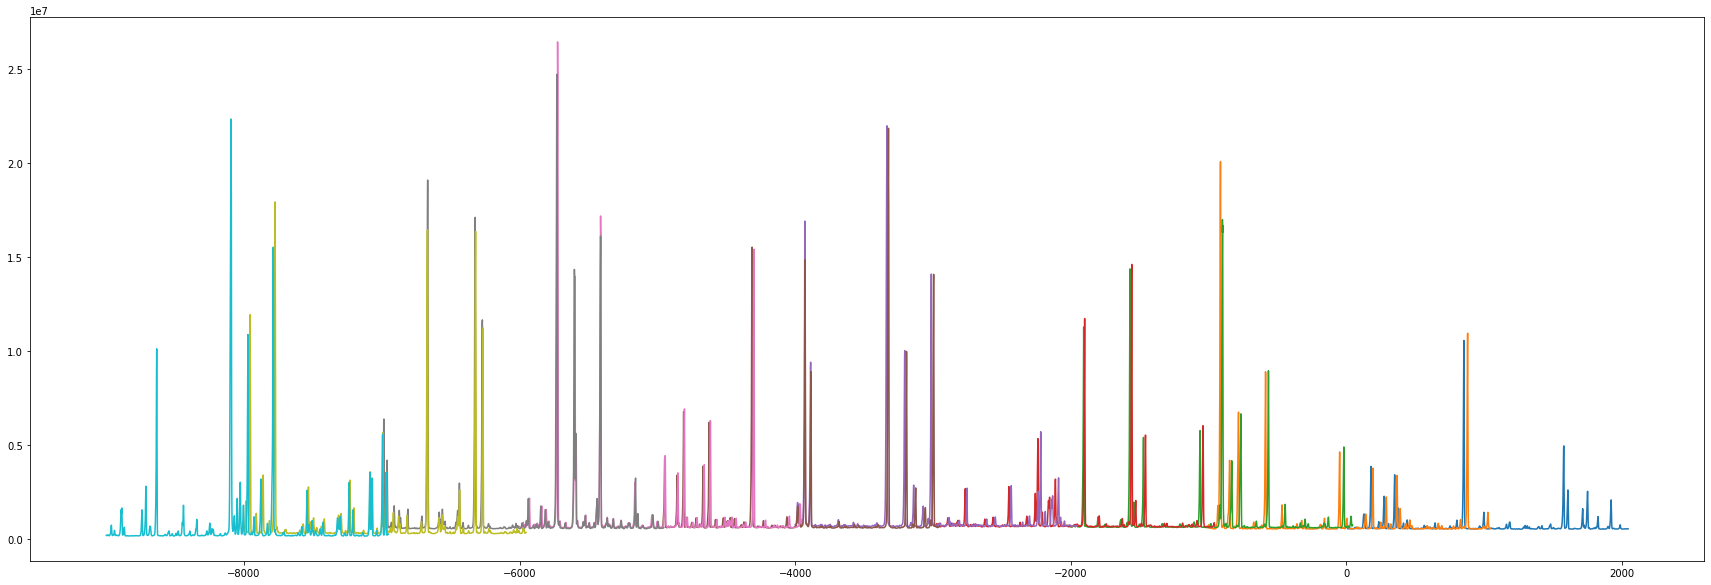

In [6]:
spectrum_data = plasma_data - back_data
plt.figure(figsize=(30, 10))
for s in spectrum_data:
  plt.plot(s['long_x'], s)

# 波長校正

In [7]:
wavelength_par_pixel = np.zeros(8)
wavelengths = np.zeros((len(spectrum_data), len(spectrum_data[0])))
spectrum_data_array = np.zeros((len(spectrum_data), len(spectrum_data[0])))

            2
-6.989e-08 x - 0.004309 x + 606.8
wavelength
[597.72420821 597.72880375 597.73339915 ... 606.82994656 606.83425625
 606.8385658 ]


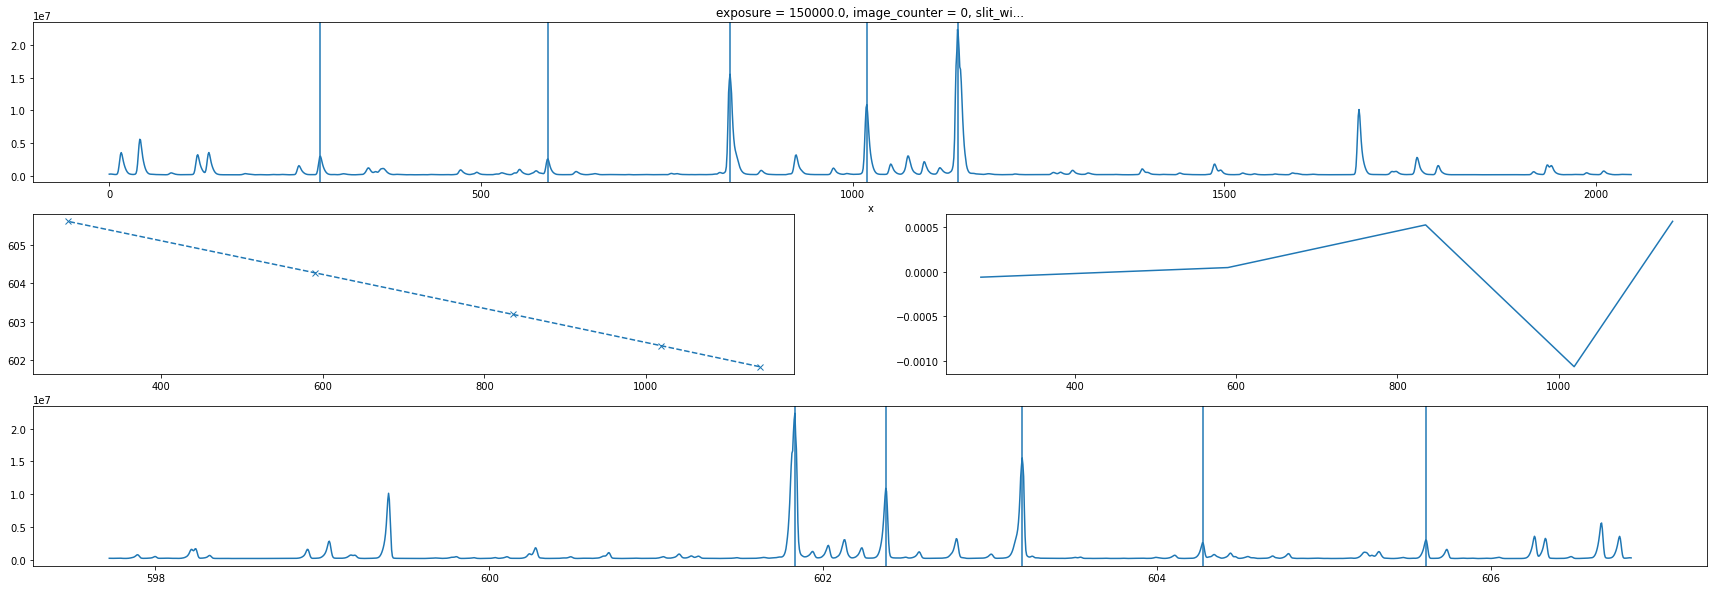

In [8]:
plt.figure(figsize=(30, 10))

wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
]

pixels = [
  1141,
  1019,
  835,
  590,
  284
]

plt.subplot(3, 1, 1)
spectrum_data.sel(motor_coordinate=465000).plot()
for p in pixels:
  plt.axvline(p)
plt.subplot(3, 2, 3)
plt.plot(pixels, wave_lengths, marker='x', linestyle='dashed')

func = np.poly1d(np.polyfit(pixels, wave_lengths, 2))
print(func)
plt.subplot(3, 2, 4)
plt.plot(pixels, func(pixels) - wave_lengths)

for j, b in enumerate(spectrum_data.sel(motor_coordinate=465000)[::-1]):
  wavelengths[0][j] = func(int(b['x'].values))
  spectrum_data_array[0][j] = b.values
print('wavelength')
print(wavelengths[0])

plt.subplot(3, 1, 3)
plt.plot(wavelengths[0], spectrum_data.sel(motor_coordinate=465000)[::-1])
for w in wave_lengths:
  plt.axvline(w)

            2
-1.319e-07 x - 0.004071 x + 611
wavelength
[602.15770788 602.1623182  602.16692826 ... 611.0346557  611.03872673
 611.04279749]


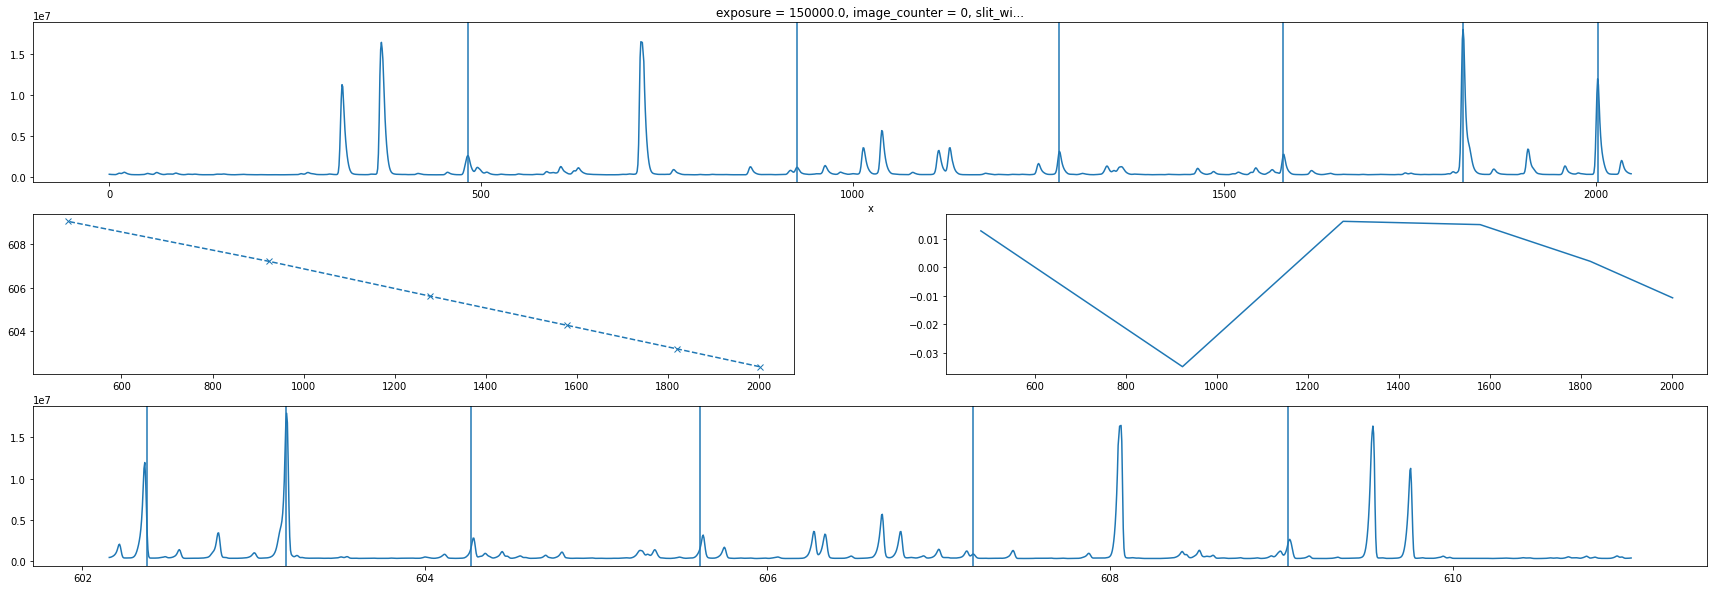

In [9]:
plt.figure(figsize=(30, 10))

wave_lengths = [
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
]

pixels = [
  2002,
  1821,
  1579,
  1278,
  925,
  482
]
plt.subplot(3, 1, 1)
spectrum_data.sel(motor_coordinate=460000).plot()
for p in pixels:
  plt.axvline(p)
wavelength_par_pixel[1] = (wave_lengths[-1]-wave_lengths[0]) / (pixels[0]-pixels[-1])

plt.subplot(3, 2, 3)
plt.plot(pixels, wave_lengths, marker='x', linestyle='dashed')

func = np.poly1d(np.polyfit(pixels, wave_lengths, 2))
print(func)
plt.subplot(3, 2, 4)
plt.plot(pixels, func(pixels) - wave_lengths)

for j, b in enumerate(spectrum_data.sel(motor_coordinate=460000)[::-1]):
  wavelengths[1][j] = func(int(b['x'].values))
  spectrum_data_array[1][j] = b.values
print('wavelength')
print(wavelengths[1])

plt.subplot(3, 1, 3)
plt.plot(wavelengths[1], spectrum_data.sel(motor_coordinate=460000)[::-1])
for w in wave_lengths:
  plt.axvline(w)


 
-0.004367 x + 615.5
wavelength
[606.60170759 606.60607414 606.61044069 ... 615.53129663 615.53566317
 615.54002972]


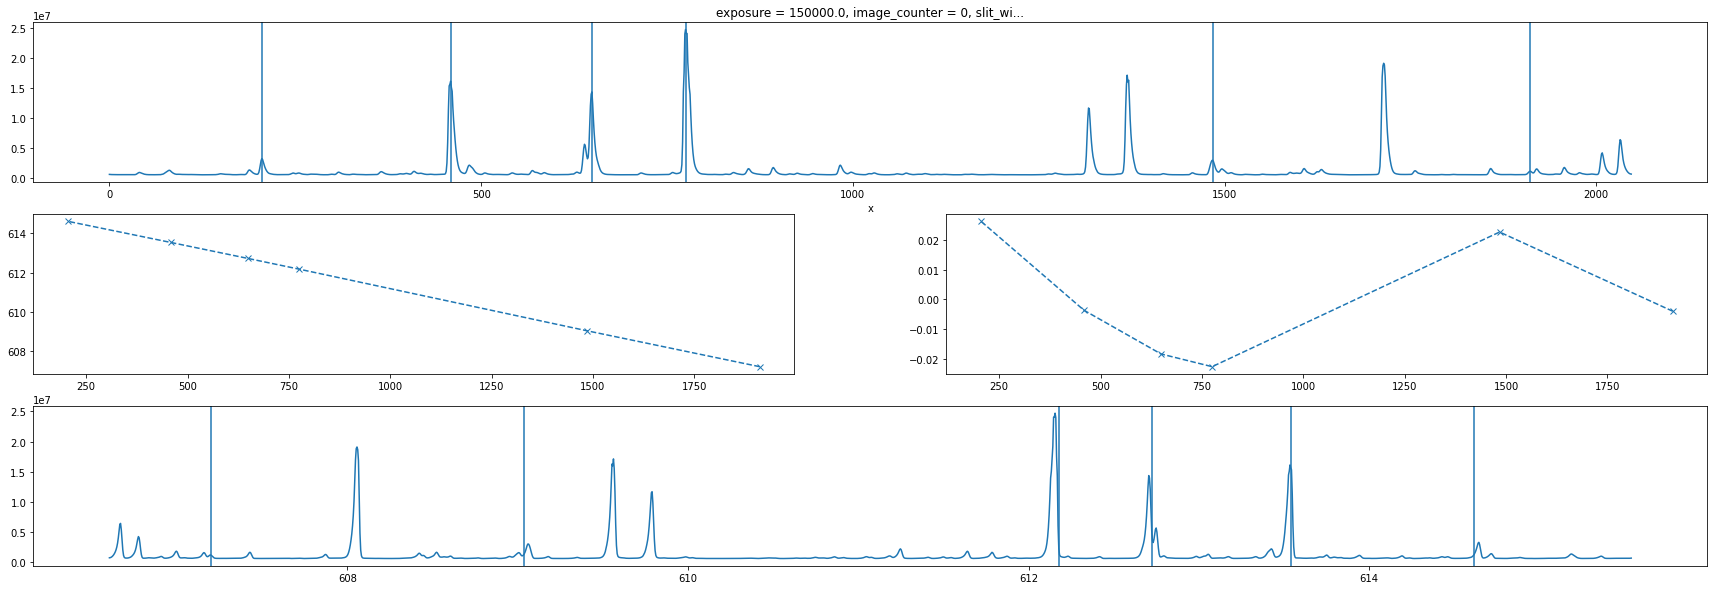

In [10]:
plt.figure(figsize=(30, 10))

wave_lengths = [
  607.1996,
  609.0374,
  612.1787,
  612.7246,
  613.5395,
  614.6186,
]

pixels = [
  1911,
  1484,
  775,
  649,
  459,
  205
]
plt.subplot(3, 1, 1)
spectrum_data.sel(motor_coordinate=455000).plot()
for p in pixels:
  plt.axvline(p)
wavelength_par_pixel[2] = (wave_lengths[-1]-wave_lengths[0]) / (pixels[0]-pixels[-1])
#plt.xlim(1900, 1930)
#plt.ylim(0, 2e6)

plt.subplot(3, 2, 3)
plt.plot(pixels, wave_lengths, marker='x', linestyle='dashed')

func = np.poly1d(np.polyfit(pixels, wave_lengths, 1))
print(func)
plt.subplot(3, 2, 4)
plt.plot(pixels, func(pixels) - wave_lengths, marker='x', linestyle='dashed')

for j, b in enumerate(spectrum_data.sel(motor_coordinate=455000)[::-1]):
  wavelengths[2][j] = func(int(b['x'].values))
  spectrum_data_array[2][j] = b.values
print('wavelength')
print(wavelengths[2])

plt.subplot(3, 1, 3)
plt.plot(wavelengths[2], spectrum_data.sel(motor_coordinate=455000)[::-1])

for w in wave_lengths:
  plt.axvline(w)

           2
-6.59e-08 x - 0.004154 x + 619.7
wavelength
[610.95969065 610.96411455 610.96853831 ... 619.7311121  619.73526647
 619.73942072]


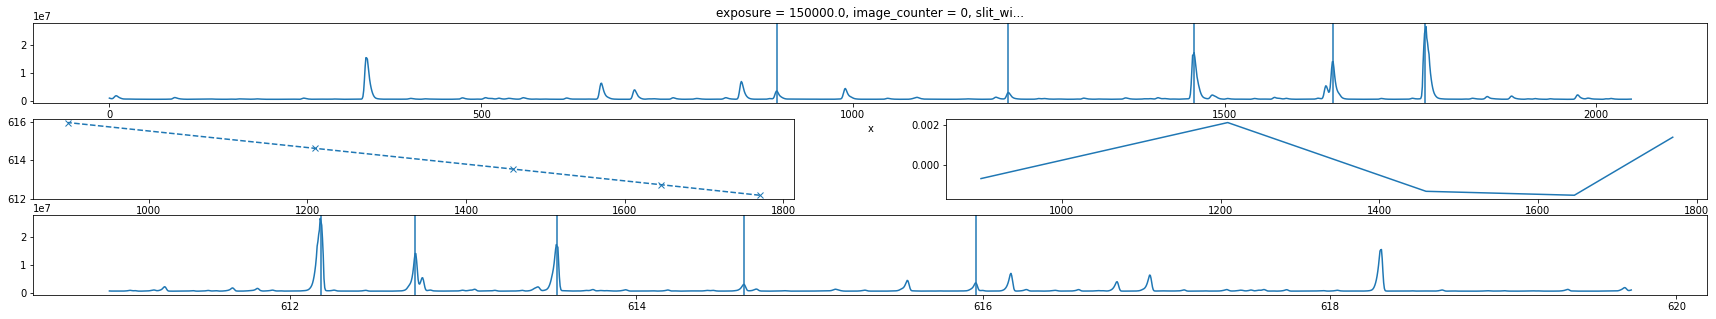

In [11]:
plt.figure(figsize=(30, 5))

wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565,
]

pixels = [
  1770,
  1646,
  1459,
  1209,
  898
]
plt.subplot(3, 1, 1)
spectrum_data.sel(motor_coordinate=450000).plot()
for p in pixels:
  plt.axvline(p)
wavelength_par_pixel[3] = (wave_lengths[-1]-wave_lengths[0]) / (pixels[0]-pixels[-1])

plt.subplot(3, 2, 3)
plt.plot(pixels, wave_lengths, marker='x', linestyle='dashed')

func = np.poly1d(np.polyfit(pixels, wave_lengths, 2))
print(func)
plt.subplot(3, 2, 4)
plt.plot(pixels, func(pixels) - wave_lengths)

for j, b in enumerate(spectrum_data.sel(motor_coordinate=450000)[::-1]):
  wavelengths[3][j] = func(int(b['x'].values))
  spectrum_data_array[3][j] = b.values
print('wavelength')
print(wavelengths[3])

plt.subplot(3, 1, 3)
plt.plot(wavelengths[3], spectrum_data.sel(motor_coordinate=450000)[::-1])
for w in wave_lengths:
  plt.axvline(w)

            2
-6.176e-08 x - 0.004113 x + 624
wavelength
[615.32903865 615.33340483 615.33777089 ... 623.99974177 624.00385537
 624.00796885]


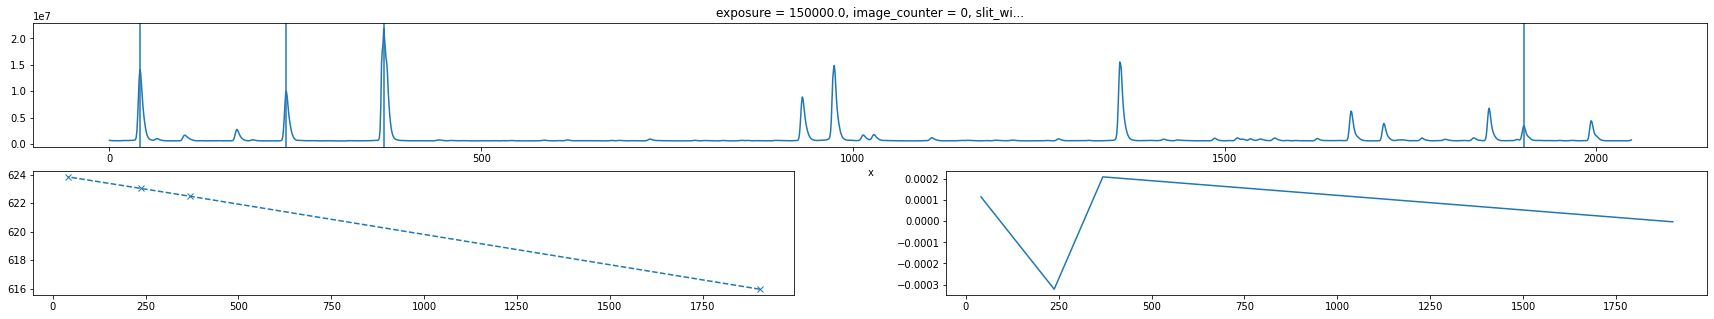

In [12]:
plt.figure(figsize=(30, 5))

wave_lengths = [
  615.9565,
  622.4815,
  623.0258,
  623.8391,
]

pixels = [
  1903,
  369,
  238,
  41
]
plt.subplot(2, 1, 1)
spectrum_data.sel(motor_coordinate=445000).plot()
for p in pixels:
  plt.axvline(p)
wavelength_par_pixel[4] = (wave_lengths[-1]-wave_lengths[0]) / (pixels[0]-pixels[-1])

plt.subplot(2, 2, 3)
plt.plot(pixels, wave_lengths, marker='x', linestyle='dashed')

func = np.poly1d(np.polyfit(pixels, wave_lengths, 2))
print(func)
plt.subplot(2, 2, 4)
plt.plot(pixels, func(pixels) - wave_lengths)

for j, b in enumerate(spectrum_data.sel(motor_coordinate=445000)[::-1]):
  wavelengths[4][j] = func(int(b['x'].values))
  spectrum_data_array[4][j] = b.values
print('wavelength')
print(wavelengths[4])

            2
-6.173e-08 x - 0.004063 x + 628.2
wavelength
[619.6305392  619.63485446 619.6391696  ... 628.19721387 628.20127665
 628.20533931]


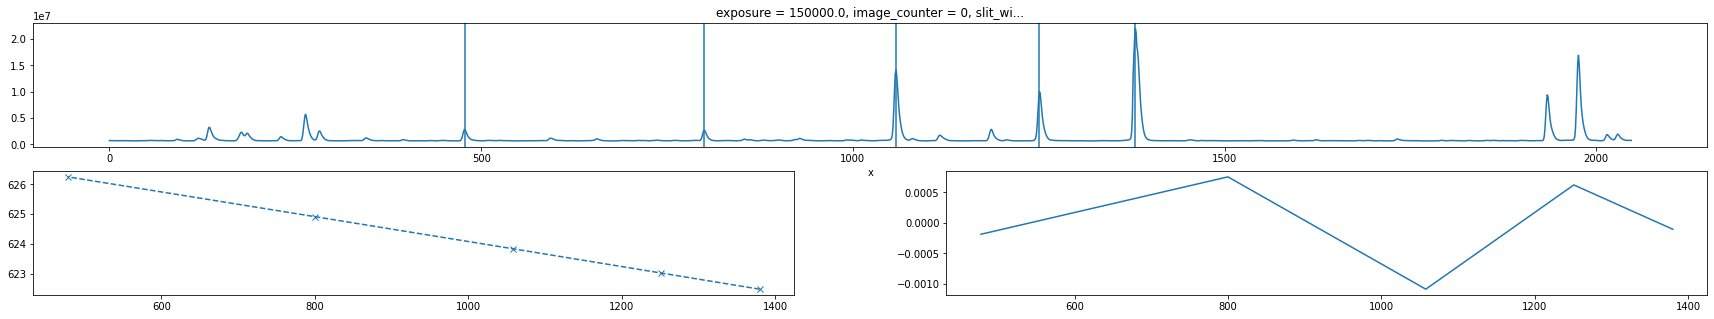

In [13]:
plt.figure(figsize=(30, 5))

wave_lengths = [
  622.4815,
  623.0258,
  623.8391,
  624.9150,
  626.2495,
]

pixels = [
  1380,
  1251,
  1058,
  800,
  478
]
plt.subplot(2, 1, 1)
spectrum_data.sel(motor_coordinate=440000).plot()
for p in pixels:
  plt.axvline(p)
wavelength_par_pixel[5] = (wave_lengths[-1]-wave_lengths[0]) / (pixels[0]-pixels[-1])

plt.subplot(2, 2, 3)
plt.plot(pixels, wave_lengths, marker='x', linestyle='dashed')

func = np.poly1d(np.polyfit(pixels, wave_lengths, 2))
print(func)
plt.subplot(2, 2, 4)
plt.plot(pixels, func(pixels) - wave_lengths)

for j, b in enumerate(spectrum_data.sel(motor_coordinate=440000)[::-1]):
  wavelengths[5][j] = func(int(b['x'].values))
  spectrum_data_array[5][j] = b.values
print('wavelength')
print(wavelengths[5])

wavelength
[623.914125   623.9183481  623.9225712  ... 632.55036709 632.55459019
 632.55881329]


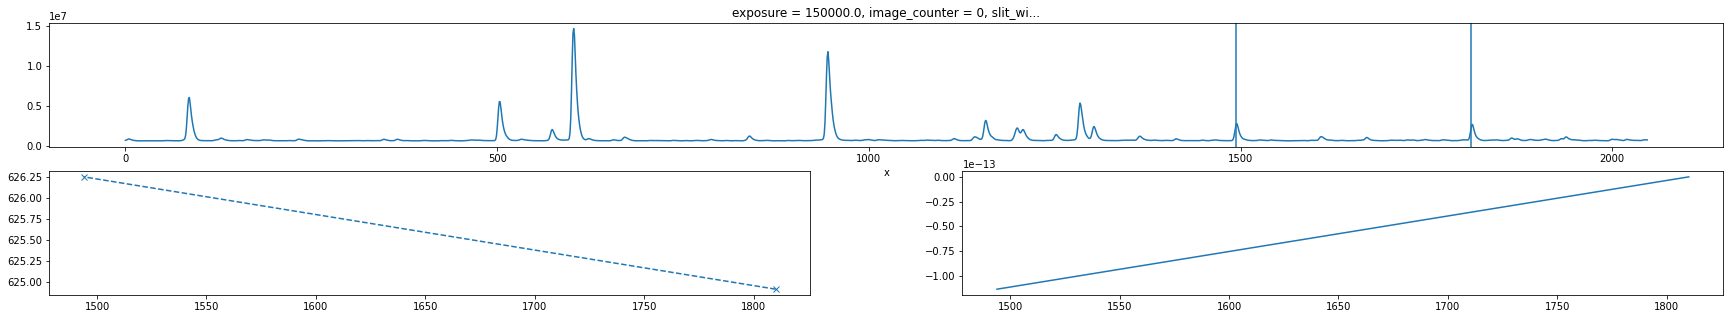

In [14]:
plt.figure(figsize=(30, 5))

wave_lengths = [
  624.9150,
  626.2495,
]

pixels = [
  1810,
  1494
]
plt.subplot(2, 1, 1)
spectrum_data.sel(motor_coordinate=435000).plot()
for p in pixels:
  plt.axvline(p)
wavelength_par_pixel[6] = (wave_lengths[-1]-wave_lengths[0]) / (pixels[0]-pixels[-1])
plt.subplot(2, 2, 3)
plt.plot(pixels, wave_lengths, marker='x', linestyle='dashed')

func = np.poly1d(np.polyfit(pixels, wave_lengths, 1))
plt.subplot(2, 2, 4)
plt.plot(pixels, func(pixels) - wave_lengths)

for j, b in enumerate(spectrum_data.sel(motor_coordinate=435000)[::-1]):
  wavelengths[6][j] = func(int(b['x'].values))
  spectrum_data_array[6][j] = b.values
print('wavelength')
print(wavelengths[6])

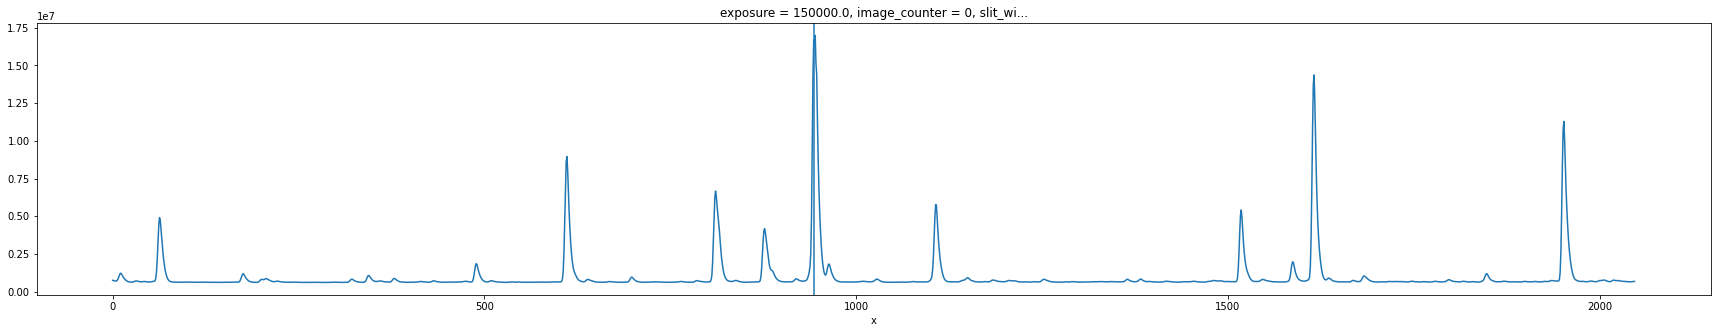

In [15]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=430000).plot()

wave_lengths = [
  637.0154,
#  637.5069,
#  638.3446,
#  639.3239,
#  640.5438,
]

pixels = [
  943,
]
for p in pixels:
  plt.axvline(p)


[[206944. 201981. 195610. ... 288176. 281545. 268253.]
 [427605. 438869. 464983. ... 344948. 352160. 363488.]
 [680194. 701798. 746313. ... 601866. 611595. 626048.]
 ...
 [     0.      0.      0. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.      0.]]
[[597.72420821 597.72880375 597.73339915 ... 606.82994656 606.83425625
  606.8385658 ]
 [602.15770788 602.1623182  602.16692826 ... 611.0346557  611.03872673
  611.04279749]
 [606.60170759 606.60607414 606.61044069 ... 615.53129663 615.53566317
  615.54002972]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


(0.0, 3000000.0)

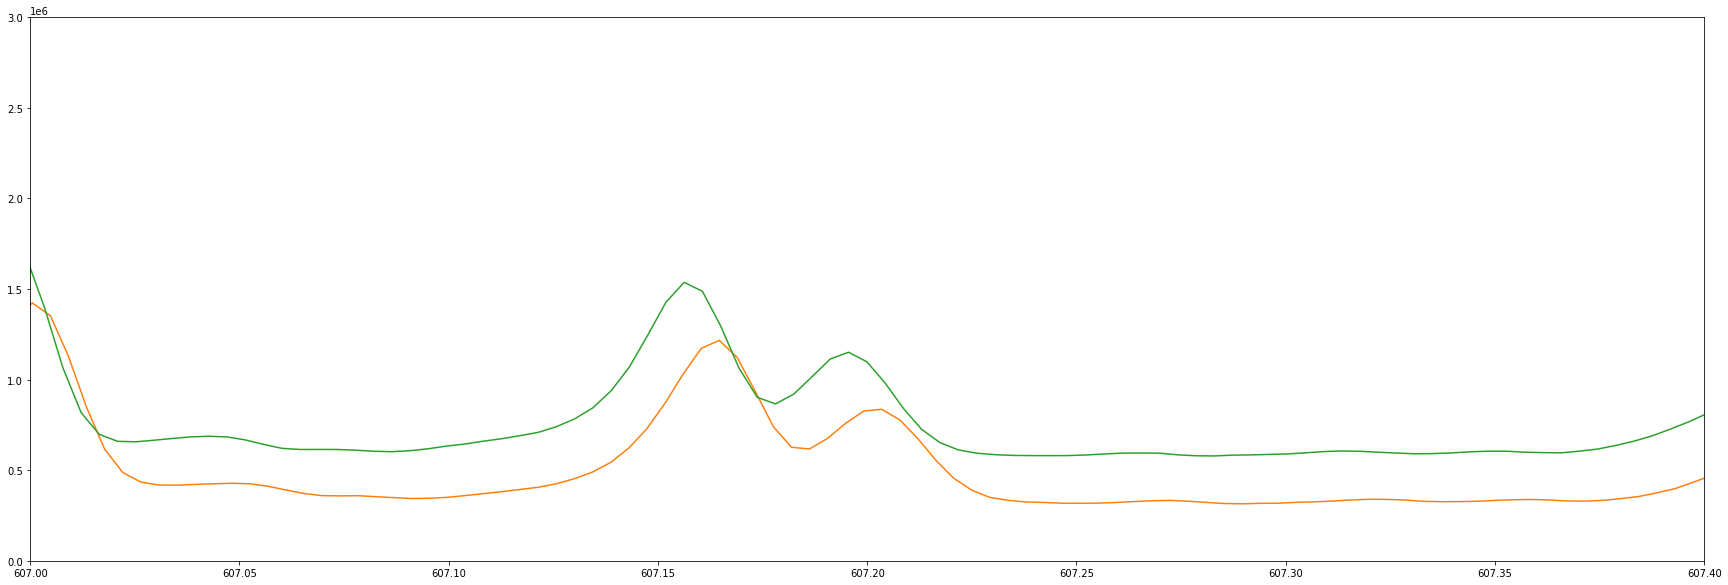

In [16]:
print(spectrum_data_array)
print(wavelengths)
plt.figure(figsize=(30, 10))
plt.plot(wavelengths[0], spectrum_data_array[0])
plt.plot(wavelengths[1], spectrum_data_array[1])
plt.plot(wavelengths[2], spectrum_data_array[2])
plt.plot(wavelengths[3], spectrum_data_array[3])
plt.plot(wavelengths[4], spectrum_data_array[4])
plt.plot(wavelengths[5], spectrum_data_array[5])
plt.plot(wavelengths[6], spectrum_data_array[6])

plt.xlim(607, 607.4)
plt.ylim(0, 3e6)

# フィッティングによる発光強度算出

## (v' - v") = (0 - 0)

{'constant_c': -1491802.9630781258, 'voigt_amplitude': 1296033.7701507432, 'voigt_center': 601.8241278668831, 'voigt_sigma': 0.011785996190009751, 'voigt_gamma': 0.011785996190009751}
{'constant_c': 27380.23425456718, 'voigt_amplitude': 395341.24266382656, 'voigt_center': 602.373645002198, 'voigt_sigma': 0.007647641704810804, 'voigt_gamma': 0.007647641704810804}
{'constant_c': 581479.0690333272, 'voigt_amplitude': 573863.5890959972, 'voigt_center': 603.1895710480234, 'voigt_sigma': 0.007948228220305609, 'voigt_gamma': 0.007948228220305609}
{'constant_c': 194919.39510945414, 'voigt_amplitude': 82733.9156604778, 'voigt_center': 604.2711589512412, 'voigt_sigma': 0.0072016778427927974, 'voigt_gamma': 0.0072016778427927974}
{'constant_c': 109337.26063857277, 'voigt_amplitude': 104743.8991017797, 'voigt_center': 605.6079148850139, 'voigt_sigma': 0.007573189129161051, 'voigt_gamma': 0.007573189129161051}
{'constant_c': 273781.5868259368, 'voigt_amplitude': 61609.99695295419, 'voigt_center': 6

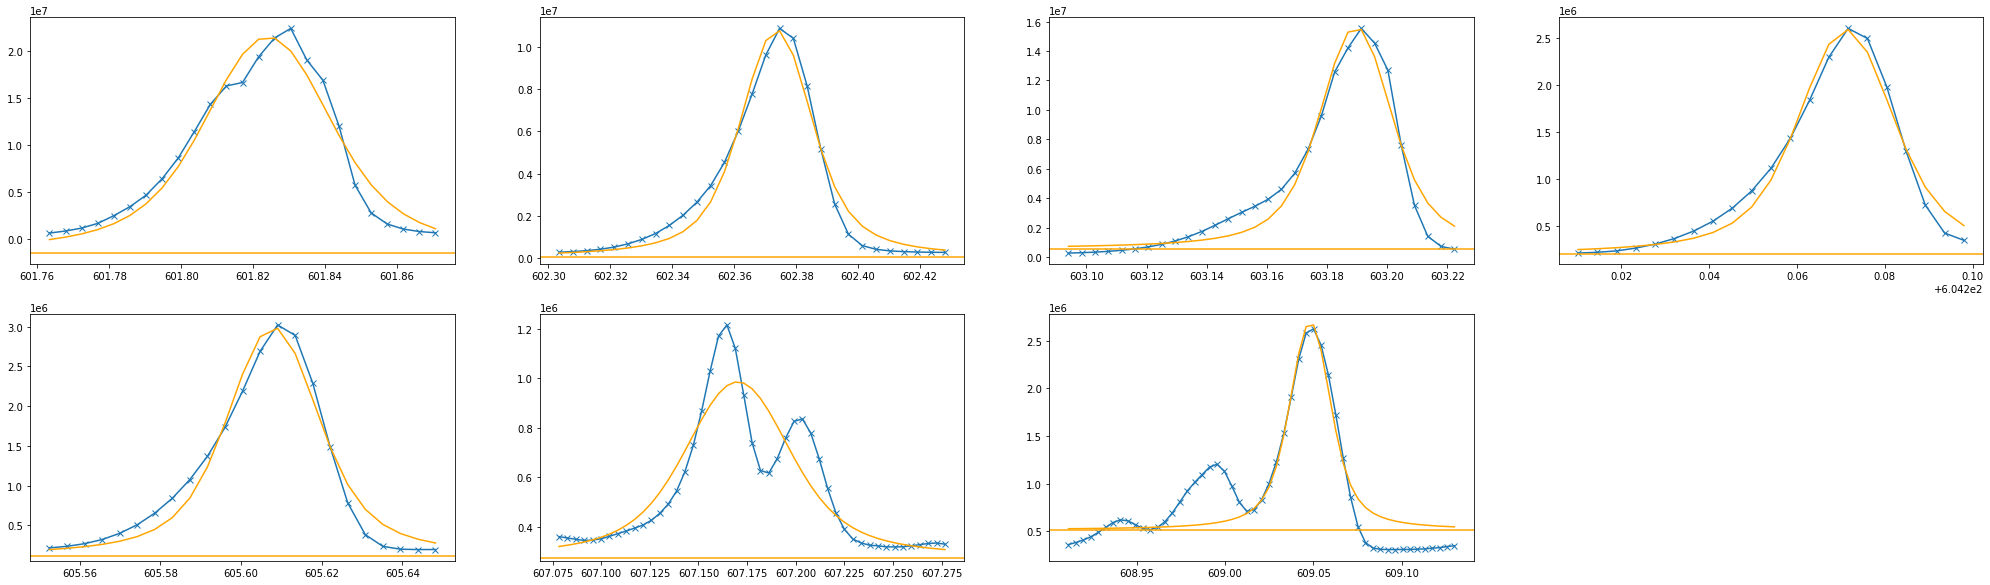

In [17]:
plt.figure(figsize=(35, 10))

args = [
  {"start": 601.76, "end": 601.875, "picture_num": 0},
  {"start": 602.3, "end": 602.43, "picture_num": 0},
  {"start": 603.09, "end": 603.225, "picture_num": 0},
  {"start": 604.21, "end": 604.3, "picture_num": 0},
  {"start": 605.55, "end": 605.65, "picture_num": 0},
  {"start": 607.075, "end": 607.28, "picture_num": 1},
  {"start": 608.91, "end": 609.13, "picture_num": 1},
]

amplitudes_0 = [] # 面積
for i, arg in enumerate(args):
  voigt_model = VoigtModel(prefix='voigt_')
  constant_model = ConstantModel(prefix='constant_')
  range = np.where((arg['start'] < wavelengths[arg['picture_num']]) & (wavelengths[arg['picture_num']] < arg['end']))[0]  
  wavelength = wavelengths[arg['picture_num']][range]
  data = spectrum_data_array[arg['picture_num']][range]
  params = voigt_model.guess(data, x=wavelength) + constant_model.guess(data, x=wavelength)
  model = voigt_model + constant_model
  result = model.fit(data, params, x = wavelength)
  plt.subplot(2, 4, i+1)
  plt.plot(wavelength, result.data, marker='x')
  plt.plot(wavelength, result.best_fit, color='orange')
  plt.axhline(result.best_values['constant_c'], color='orange')
  amplitudes_0.append(result.best_values['voigt_amplitude'])
  print(result.best_values)

amplitudes_0 = amplitudes_0

{'constant_c': 327867.07478070975, 'voigt2_amplitude': 32419.261990383548, 'voigt2_center': 607.1626056926473, 'voigt2_sigma': 0.007925447206827085, 'voigt2_gamma': 0.007925447206827085, 'voigt1_amplitude': 13820.36172344436, 'voigt1_center': 607.2029018823106, 'voigt1_sigma': 0.006069459571103275, 'voigt1_gamma': 0.006069459571103275}


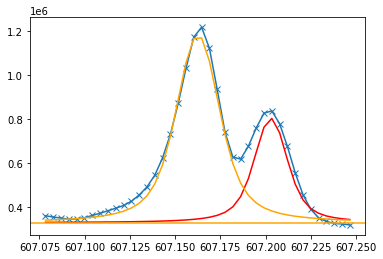

In [18]:
voigt1_model = VoigtModel(prefix='voigt1_')
voigt2_model = VoigtModel(prefix='voigt2_')
constant_model = ConstantModel(prefix='constant_')
model = voigt1_model + voigt2_model + constant_model

range = np.where((607.075 < wavelengths[1]) & (wavelengths[1] < 607.25))[0]  
wavelength = wavelengths[1][range]
data = spectrum_data_array[1][range]

params = model.make_params()
params_value = {
    'voigt1_amplitude': 10000,
    'voigt1_center': 607.20,
    'voigt1_sigma': 0.011,
    'voigt2_amplitude': 30000,
    'voigt2_center': 607.16,
    'voigt2_sigma': 0.011,
    'constant_c': 0
}
for name in model.param_names:
  params[name].set(value = params_value[name])
result = model.fit(data, params, x = wavelength)

plt.plot(wavelength, result.data, marker='x')
voigt1 = voigt(wavelength, result.best_values['voigt1_amplitude'], result.best_values['voigt1_center'], result.best_values['voigt1_sigma'])
plt.plot(wavelength, voigt1 + result.best_values['constant_c'], color='red')
voigt2 = voigt(wavelength, result.best_values['voigt2_amplitude'], result.best_values['voigt2_center'], result.best_values['voigt2_sigma'])
plt.plot(wavelength, voigt2 + result.best_values['constant_c'], color='orange')
plt.axhline(result.best_values['constant_c'], color='orange')

print(result.best_values)
amplitudes_0[5] = result.best_values['voigt1_amplitude']

{'constant_c': 186088.60882569535, 'voigt3_amplitude': 18188.091282319456, 'voigt3_center': 608.9388976421534, 'voigt3_sigma': 0.011483575777423871, 'voigt3_gamma': 0.011483575777423871, 'voigt2_amplitude': 41740.06163060872, 'voigt2_center': 608.9912013285023, 'voigt2_sigma': 0.00981825738813602, 'voigt2_gamma': 0.00981825738813602, 'voigt1_amplitude': 101330.32502494137, 'voigt1_center': 609.0488974377985, 'voigt1_sigma': 0.008651468945539031, 'voigt1_gamma': 0.008651468945539031}


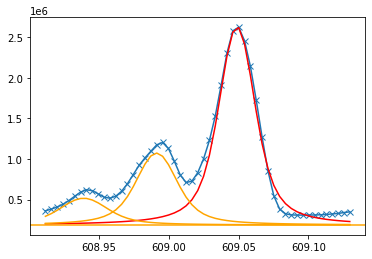

In [19]:
voigt1_model = VoigtModel(prefix='voigt1_')
voigt2_model = VoigtModel(prefix='voigt2_')
voigt3_model = VoigtModel(prefix='voigt3_')
constant_model = ConstantModel(prefix='constant_')
model = voigt1_model + voigt2_model + voigt3_model + constant_model

range = np.where((608.91 < wavelengths[1]) & (wavelengths[1] < 609.13))[0]  
wavelength = wavelengths[1][range]
data = spectrum_data_array[1][range]
params = model.make_params()
params_value = {
    'voigt1_amplitude': 90000,
    'voigt1_center': 609.05,
    'voigt1_sigma': 0.0078,
    'voigt2_amplitude': 43000,
    'voigt2_center': 608.99,
    'voigt2_sigma': 0.011,
    'voigt3_amplitude': 5000,
    'voigt3_center': 608.8,
    'voigt3_sigma': 0.011,
    'constant_c': 290000
}
for name in model.param_names:
  params[name].set(value = params_value[name])
result = model.fit(data, params, x = wavelength)

plt.plot(wavelength, result.data, marker='x')
voigt1 = voigt(wavelength, result.best_values['voigt1_amplitude'], result.best_values['voigt1_center'], result.best_values['voigt1_sigma'])
plt.plot(wavelength, voigt1 + result.best_values['constant_c'], color='red')
voigt2 = voigt(wavelength, result.best_values['voigt2_amplitude'], result.best_values['voigt2_center'], result.best_values['voigt2_sigma'])
plt.plot(wavelength, voigt2 + result.best_values['constant_c'], color='orange')
voigt3 = voigt(wavelength, result.best_values['voigt3_amplitude'], result.best_values['voigt3_center'], result.best_values['voigt3_sigma'])
plt.plot(wavelength, voigt3 + result.best_values['constant_c'], color='orange')
plt.axhline(result.best_values['constant_c'], color='orange')

print(result.best_values)
amplitudes_0[6] = result.best_values['voigt1_amplitude']

## (v' - v") = (1 - 1)

{'constant_c': -39458.83768516898, 'voigt_amplitude': 1270092.8055444094, 'voigt_center': 612.1740152288132, 'voigt_sigma': 0.010152773830591988, 'voigt_gamma': 0.010152773830591988}
{'constant_c': 1051710.379627344, 'voigt_amplitude': 477977.79420820053, 'voigt_center': 612.7242017345243, 'voigt_sigma': 0.00788883468530166, 'voigt_gamma': 0.00788883468530166}
{'constant_c': 657970.5403593482, 'voigt_amplitude': 667092.5523777197, 'voigt_center': 613.537497432272, 'voigt_sigma': 0.00826620317587845, 'voigt_gamma': 0.00826620317587845}
{'constant_c': 645712.1234200548, 'voigt_amplitude': 85425.15761270825, 'voigt_center': 614.6179542702109, 'voigt_sigma': 0.007510581557842899, 'voigt_gamma': 0.007510581557842899}
{'constant_c': 648294.730777356, 'voigt_amplitude': 102321.95723384462, 'voigt_center': 615.9555776780394, 'voigt_sigma': 0.007459363052482848, 'voigt_gamma': 0.007459363052482848}


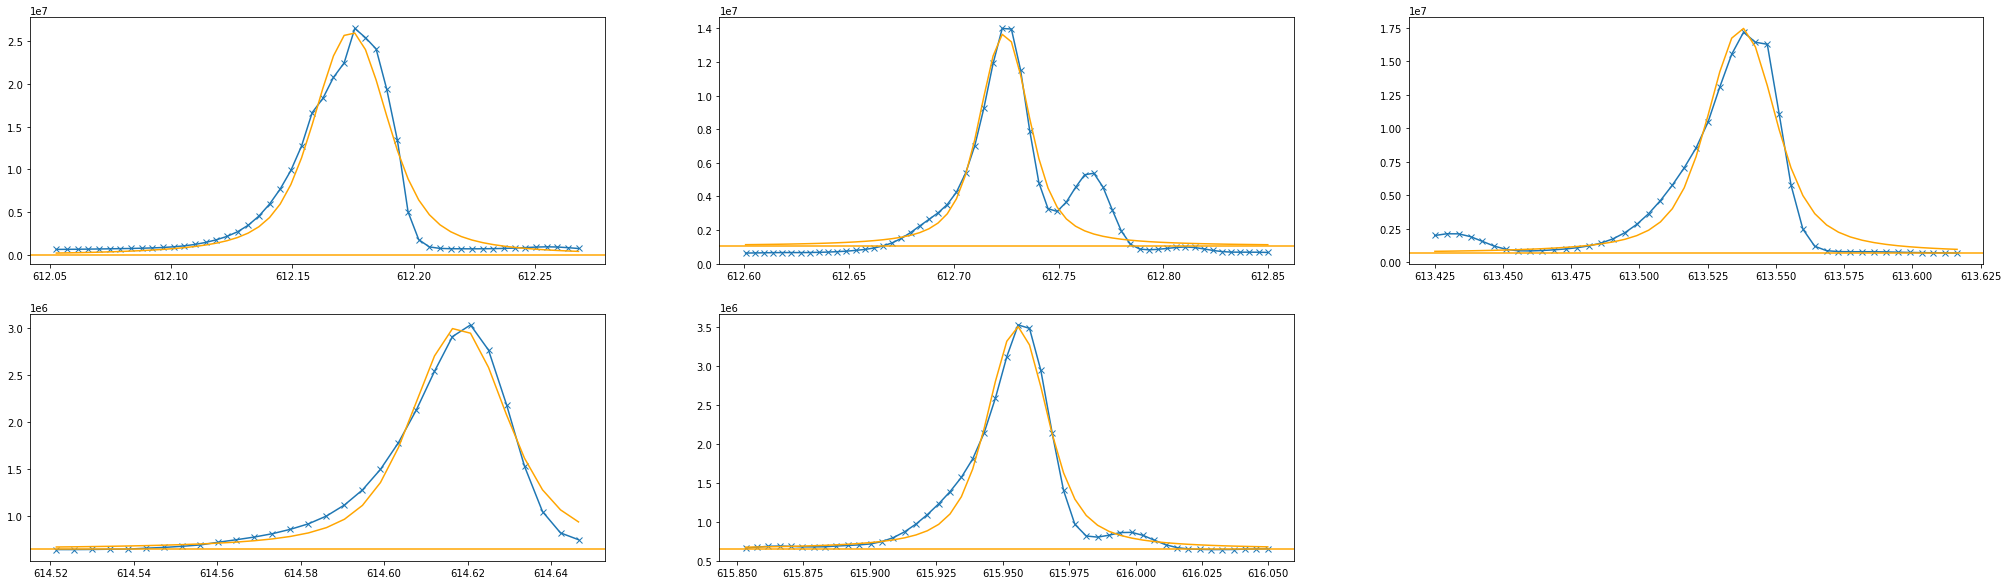

In [20]:
plt.figure(figsize=(35, 10))

args = [
  {"start": 612.05, "end": 612.27, "picture_num": 3},
  {"start": 612.6, "end": 612.85, "picture_num": 3},
  {"start": 613.425, "end": 613.62, "picture_num": 3},
  {"start": 614.52, "end": 614.65, "picture_num": 3},
  {"start": 615.85, "end": 616.05, "picture_num": 3},
]

amplitudes_1 = [] # 面積
for i, arg in enumerate(args):
  voigt_model = VoigtModel(prefix='voigt_')
  constant_model = ConstantModel(prefix='constant_')
  range = np.where((arg['start'] < wavelengths[arg['picture_num']]) & (wavelengths[arg['picture_num']] < arg['end']))[0]  
  wavelength = wavelengths[arg['picture_num']][range]
  data = spectrum_data_array[arg['picture_num']][range]
  params = voigt_model.guess(data, x=wavelength) + constant_model.guess(data, x=wavelength)
  model = voigt_model + constant_model
  result = model.fit(data, params, x = wavelength)
  plt.subplot(2, 3, i+1)
  plt.plot(wavelength, result.data, marker='x')
  plt.plot(wavelength, result.best_fit, color='orange')
  plt.axhline(result.best_values['constant_c'], color='orange')
  amplitudes_1.append(result.best_values['voigt_amplitude'])
  print(result.best_values)

amplitudes_1[1] = 0
amplitudes_1[4] = 0

{'constant_c': 686839.7023130574, 'voigt2_amplitude': 98385.482060451, 'voigt2_center': 612.7657287038239, 'voigt2_sigma': 0.0047855283049396125, 'voigt2_gamma': 0.0047855283049396125, 'voigt1_amplitude': 473620.50083513884, 'voigt1_center': 612.7237535146785, 'voigt1_sigma': 0.007507165664584647, 'voigt1_gamma': 0.007507165664584647}


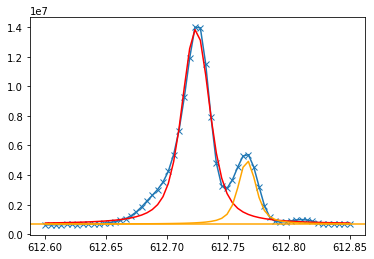

In [24]:
voigt1_model = VoigtModel(prefix='voigt1_')
voigt2_model = VoigtModel(prefix='voigt2_')
constant_model = ConstantModel(prefix='constant_')
model = voigt1_model + voigt2_model + constant_model

range = np.where((612.6 < wavelengths[3]) & (wavelengths[3] < 612.85))[0]  
wavelength = wavelengths[3][range]
data = spectrum_data_array[3][range]
params = model.make_params()
params_value = {
    'voigt1_amplitude': 400000,
    'voigt1_center': 612.73,
    'voigt1_sigma': 0.0088,
    'voigt2_amplitude': 40000,
    'voigt2_center': 612.77,
    'voigt2_sigma': 0.011,
    'constant_c': 1e6
}
for name in model.param_names:
  params[name].set(value = params_value[name])
result = model.fit(data, params, x = wavelength)

plt.plot(wavelength, result.data, marker='x')
voigt1 = voigt(wavelength, result.best_values['voigt1_amplitude'], result.best_values['voigt1_center'], result.best_values['voigt1_sigma'])
plt.plot(wavelength, voigt1 + result.best_values['constant_c'], color='red')
voigt2 = voigt(wavelength, result.best_values['voigt2_amplitude'], result.best_values['voigt2_center'], result.best_values['voigt2_sigma'])
plt.plot(wavelength, voigt2 + result.best_values['constant_c'], color='orange')
plt.axhline(result.best_values['constant_c'], color='orange')

print(result.best_values)
amplitudes_1[1] = result.best_values['voigt1_amplitude']

{'constant_c': 604797.4493802569, 'voigt2_amplitude': 8000, 'voigt2_center': 616, 'voigt2_sigma': 0.00813, 'voigt2_gamma': 0.00813, 'voigt1_amplitude': 103669.61523821134, 'voigt1_center': 615.9554011763694, 'voigt1_sigma': 0.007470107633574363, 'voigt1_gamma': 0.007470107633574363}


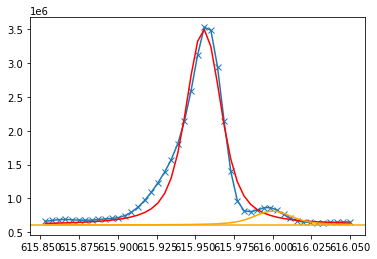

In [27]:
voigt1_model = VoigtModel(prefix='voigt1_')
voigt2_model = VoigtModel(prefix='voigt2_')
constant_model = ConstantModel(prefix='constant_')
model = voigt1_model + voigt2_model + constant_model

range = np.where((615.85 < wavelengths[3]) & (wavelengths[3] < 616.05))[0]  
wavelength = wavelengths[3][range]
data = spectrum_data_array[3][range]
params = model.make_params()
params_value = {
    'voigt1_amplitude': 51300,
    'voigt1_center': 615.95,
    'voigt1_sigma': 0.0080,
    'voigt2_amplitude': 7000,
    'voigt2_center': 615.99,
    'voigt2_sigma': 0.00813,
    'constant_c': 640000
}
for name in model.param_names:
  params[name].set(value = params_value[name])
params['voigt2_center'].set(value=616, vary=False)
params['voigt2_sigma'].set(value=0.00813, vary=False)
params['voigt2_amplitude'].set(value=8000, vary=False)
result = model.fit(data, params, x = wavelength)

plt.plot(wavelength, result.data, marker='x')
voigt1 = voigt(wavelength, result.best_values['voigt1_amplitude'], result.best_values['voigt1_center'], result.best_values['voigt1_sigma'])
plt.plot(wavelength, voigt1 + result.best_values['constant_c'], color='red')
voigt2 = voigt(wavelength, result.best_values['voigt2_amplitude'], result.best_values['voigt2_center'], result.best_values['voigt2_sigma'])
plt.plot(wavelength, voigt2 + result.best_values['constant_c'], color='orange')
plt.axhline(result.best_values['constant_c'], color='orange')

print(result.best_values)
amplitudes_1[4] = result.best_values['voigt1_amplitude']

## (v' - v") = (2 - 2)

{'constant_c': -369762.5702335625, 'voigt_amplitude': 1088297.469921676, 'voigt_center': 622.4761250891474, 'voigt_sigma': 0.010235954907722888, 'voigt_gamma': 0.010235954907722888}
{'constant_c': 693090.9913420727, 'voigt_amplitude': 321783.22059643734, 'voigt_center': 623.0232543234243, 'voigt_sigma': 0.007248384234068483, 'voigt_gamma': 0.007248384234068483}
{'constant_c': 596898.1912107767, 'voigt_amplitude': 476536.7985361704, 'voigt_center': 623.8361217729903, 'voigt_sigma': 0.007332938667433453, 'voigt_gamma': 0.007332938667433453}
{'constant_c': 713934.9008982679, 'voigt_amplitude': 67123.41850279296, 'voigt_center': 624.913415844499, 'voigt_sigma': 0.00704565548169378, 'voigt_gamma': 0.00704565548169378}
{'constant_c': 701843.8960241311, 'voigt_amplitude': 72595.52639359549, 'voigt_center': 626.2479399521276, 'voigt_sigma': 0.007106244870813239, 'voigt_gamma': 0.007106244870813239}


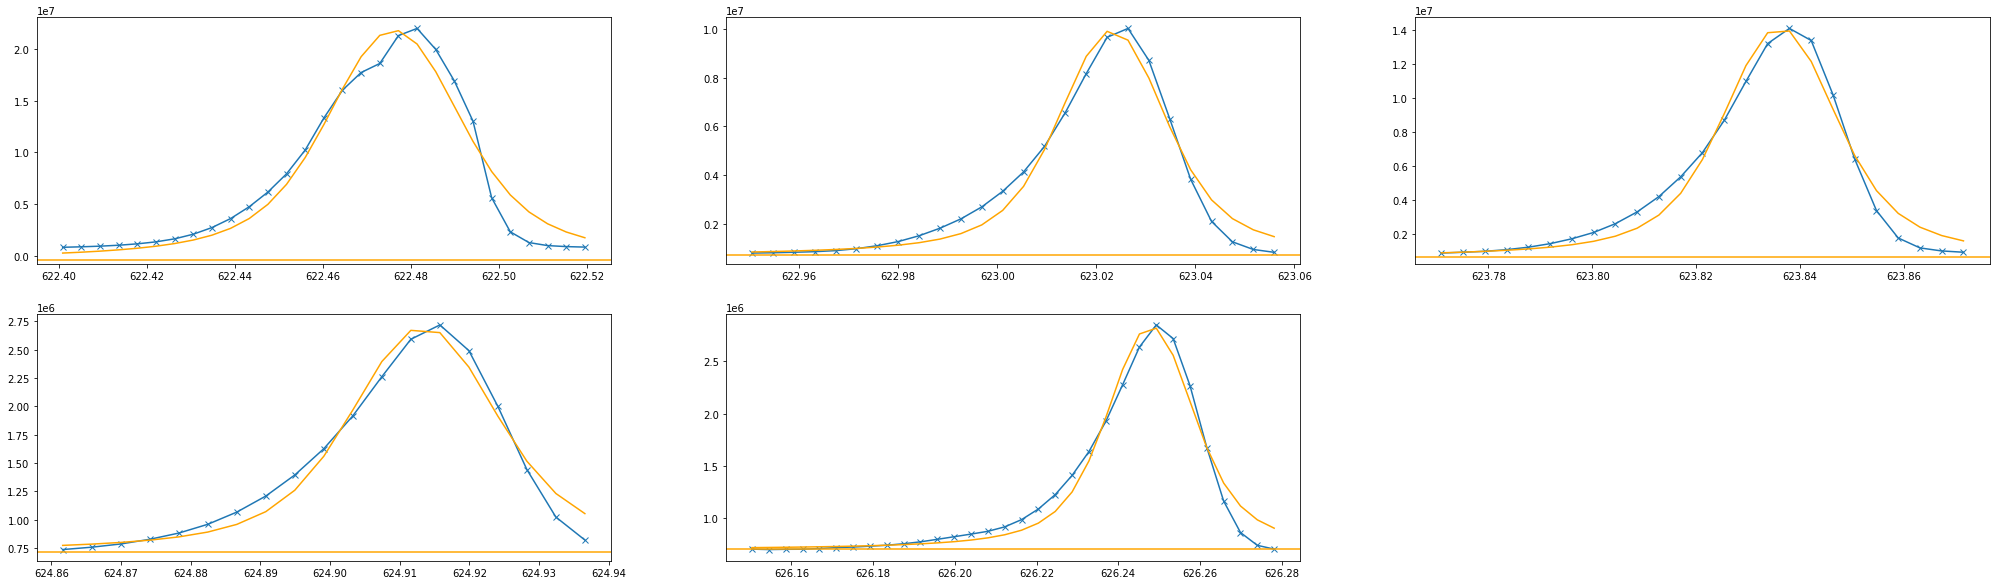

In [29]:
plt.figure(figsize=(35, 10))

args = [
  {"start": 622.4, "end": 622.52, "picture_num": 5},
  {"start": 622.95, "end": 623.06, "picture_num": 5},
  {"start": 623.77, "end": 623.875, "picture_num": 5},
  {"start": 624.86, "end": 624.94, "picture_num": 5},
  {"start": 626.15, "end": 626.28, "picture_num": 5},
]

amplitudes_2 = [] # 面積
for i, arg in enumerate(args):
  voigt_model = VoigtModel(prefix='voigt_')
  constant_model = ConstantModel(prefix='constant_')
  range = np.where((arg['start'] < wavelengths[arg['picture_num']]) & (wavelengths[arg['picture_num']] < arg['end']))[0]  
  wavelength = wavelengths[arg['picture_num']][range]
  data = spectrum_data_array[arg['picture_num']][range]
  params = voigt_model.guess(data, x=wavelength) + constant_model.guess(data, x=wavelength)
  model = voigt_model + constant_model
  result = model.fit(data, params, x = wavelength)
  plt.subplot(2, 3, i+1)
  plt.plot(wavelength, result.data, marker='x')
  plt.plot(wavelength, result.best_fit, color='orange')
  plt.axhline(result.best_values['constant_c'], color='orange')
  amplitudes_2.append(result.best_values['voigt_amplitude'])
  print(result.best_values)


In [30]:
print(amplitudes_0)
print(amplitudes_1)
print(amplitudes_2)

[1296033.7701507432, 395341.24266382656, 573863.5890959972, 82733.9156604778, 104743.8991017797, 13820.36172344436, 101330.32502494137]
[1270092.8055444094, 473620.50083513884, 667092.5523777197, 85425.15761270825, 103669.61523821134]
[1088297.469921676, 321783.22059643734, 476536.7985361704, 67123.41850279296, 72595.52639359549]


# ファイルに保存

In [31]:
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
]
array_0 = xr.DataArray(amplitudes_0, dims=['dN'], coords=[('dN', np.arange(1, 8))])
array_0 = array_0.assign_coords(wavelength=('dN', wave_lengths))
array_0 = array_0.assign_coords(intensity=('dN', amplitudes_0))

wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565
]
array_1 = xr.DataArray(amplitudes_1, dims=['dN'], coords=[('dN', np.arange(1, 6))])
array_1 = array_1.assign_coords(wavelength=('dN', wave_lengths))
array_1 = array_1.assign_coords(intensity=('dN', amplitudes_1))

wave_lengths = [
  622.4815,
  623.0258,
  623.8391,
  624.9150,
  626.2495,
]
array_2 = xr.DataArray(amplitudes_2, dims=['dN'], coords=[('dN', np.arange(1, 6))])
array_2 = array_2.assign_coords(wavelength=('dN', wave_lengths))
array_2 = array_2.assign_coords(intensity=('dN', amplitudes_2))


In [32]:
array_0.to_netcdf(join(data_path, '/content/drive/MyDrive/研究室/myLeprecon/niihama/analyze_1-4/array_0.nc'))
array_1.to_netcdf(join(data_path, '/content/drive/MyDrive/研究室/myLeprecon/niihama/analyze_1-4/array_1.nc'))
array_2.to_netcdf(join(data_path, '/content/drive/MyDrive/研究室/myLeprecon/niihama/analyze_1-4/array_2.nc'))
